In [73]:
#Importing and installing modules
import json
import os
import requests
import numpy as np
from bs4 import BeautifulSoup
from PIL import Image
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from matplotlib import pyplot as plt

In [74]:
#Setting the base url where the speeches are stored
base_url = 'https://www.gov.br/planalto/pt-br/acompanhe-o-planalto/pronunciamentos/pronunciamentos-do-presidente-da-republica'
data_dir = 'pronunciamentos'

In [75]:
#getting a response from that url
response = requests.get(base_url)

In [76]:
#Saving the response text on a BS object
bs = BeautifulSoup(response.text)

In [77]:
#The speeches have a html tag 'article' so we get them all and save them on a list 'articles'
articles = bs.find_all('article')

In [155]:
#To check the data we name the first input of the list articles 'article' and using BS find methods we can get the url (class summary url on html code), tags (rel = 'tag' on html code) and datetime (class 'summary view icon' on html code)
article = articles[0]
url = article.find(class_ = "summary url")
tags = article.find_all(rel = 'tag')
datetime = article.find_all(class_ = "summary-view-icon")

In [156]:
#Using list comprehension we can get the exact link of the first speech (article = articles[0])
url['href']

'https://www.gov.br/planalto/pt-br/acompanhe-o-planalto/pronunciamentos/pronunciamentos-do-presidente-da-republica/pronunciamento-do-presidente-da-republica-jair-bolsonaro-em-cadeia-de-radio-e-televisao-brasilia-df'

In [157]:
#Using a for loop  we can get only the text for the tags stored on the list tags
tags = [t.text for t in tags]
tags

['Pronunciamento', 'Presidente', 'Nova Previdência']

In [158]:
#With list comprehension we split date and time
date = datetime[0].text.strip()
time = datetime[1].text.strip()

In [159]:
#In order to filter the speeches later we create a function to convert the date to a canonical date
def canonical_date(datestr):
    return ''.join(reversed(datestr.split('/')))

In [160]:
#Checking the canonical date
canonical_date(date)

'20190220'

In [161]:
#The class pronouncement holds the methods used to get the attributes and text from the articles, store them in json and load them from json
#In the init function we get the objects using BS as we did with the first speech(articles[0])
#For the text extraction we create a hidden method extract self to find the id 'parent-fieldname-text' and get its text
#Then we also we create a method do dump the json file and other to load it

class Pronouncement:
    def __init__(self, bs_article=None):
        if bs_article is not None:
            datetime = bs_article.find_all(class_ = "summary-view-icon")
            self.url = bs_article.find(class_ = "summary url")['href']
            self.tags = [t.text for t in bs_article.find_all(rel='tag')]
            self.date = canonical_date(datetime[0].text.strip())
            self.time = datetime[1].text.strip()
            self.text = self._extract_text()

    def _extract_text(self):
        r = requests.get(self.url)
        bs = BeautifulSoup(r.text)
        return bs.find(id='parent-fieldname-text').text.strip()

    def save_tojson(p, savedir, name=None):
        if name is None:
            name = f"{p.date}-{p.time}.json"
        path = os.path.join(savedir, name)
        with open(path, "w") as jsonfile:
            json.dump(p.__dict__, jsonfile)

    def load_fromjson(filepath):
        with open(filepath,'r', encoding="utf-8") as jsonfile:
            data = json.load(jsonfile)
            p = Pronouncement()
            p.date = data['date']
            p.time = data['time']
            p.tags = data['tags']
            p.url = data['url']
            p.text = data['text']
            return p


In [162]:
#For each article in the articles list we apply the class pronouncement that we've just created in order to get the attributes
pronouncements = [Pronouncement(art) for art in articles]

In [163]:
#Then we save each one as a separate json file
for p in pronouncements:
  Pronouncement.save_tojson(p, data_dir)

In [164]:
#Check for the amount of pronouncements stored
len(pronouncements)

18

In [165]:
#We check for the files on dir and load them to the 'pronunciamentos' list
filenames = os.listdir(data_dir)
pronunciamentos = []
for name in filenames:
    path = os.path.join(data_dir,name)
    pronunciamentos.append(Pronouncement.load_fromjson(path))

In [166]:
#And check the loaded to see if it matches the ones saved
len(pronunciamentos)

18

In [190]:
#Here we filter for the pronouncements since the beggining of the covid19 outbreak in Brazil in march 2021 and join them all on a single string object
pronunciamentos_concatenados = []
for p in pronunciamentos:
    if p.date > '20200301':
        pronunciamentos_concatenados.append(p.text)
pronunciamentos_concatenados = ' '.join(map(str,pronunciamentos_concatenados))

In [218]:
#Defining the stopwords - words which its meaning doesn't aggregate value to the cloud analysis
stopwords = set(STOPWORDS)
stopwords.update(['da','meu','em','você','de','ao','os','que','nós','não','mais','todo','se','eu','uma'
                    ,'na','como','por','um','das','no','também','então','e','o','é','para','todos','essa',
                    'esse','nossa','nos','dos','temos','tem','à','muito','ser','nosso','seu','ele','sua','ela',
                    'são','ou','ano','mas','todo','até','aos','foi','cada','já'])

In [219]:
#Defining the parameters for the wordcloud
wordcloud = WordCloud(stopwords=stopwords,
                        background_color = 'black',
                        width = 1000, height = 1000,
                        max_font_size = 200,
                        min_font_size = 1,
                        max_words = 300).generate(pronunciamentos_concatenados)

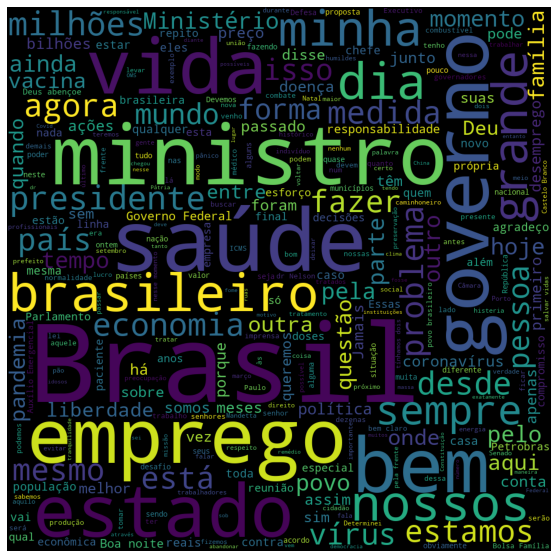

In [221]:
#Showing and saving the image with the wordcloud
fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(wordcloud, interpolation = 'bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)
wordcloud.to_file('WordCloudBolsonaroPronouncements.png')